# Using beamforming to localize oscillatory power modulations

The aim of this section is to localize the modulations of oscillatory power. The will be done using the Dynamical Imaging of Coherent Sources (DICS) approach (Gross et al, 2001). This is a beamforming methodology based on spatial filtering operating in the frequency domain. For each grid point in the brain, a spatial filter is derived based on the forward model and the cross-spectral density (CSD) matrix. A multitaper approach is applied for the spectral estimates.
The approach allows for estimating the power modulations at each grid points which then is mapped onto the indiviual structural MRIs. Prewhitening of the data allows for combining the information from the gradiometers and the magnetomers 


## Preparation

Import the relevant Python modules:

In [1]:
import os
import os.path as op
import numpy as np

import mne
from mne.cov import compute_covariance
from mne.beamformer import make_dics, apply_dics_csd
from mne.time_frequency import csd_multitaper

Set the paths and name for the data. Note that these will depend on your local setup.

In [2]:
# The fif data
result_path = r'C:\Users\JensenO\Dropbox\FLUX\Development\dataResults'
file_name = 'training_epo.fif'
path_file  = op.join(result_path,file_name)

# Files for plotting the source data on the MRI
src_fname = r'C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1-surfaceoct6_src.fif'
mri_dir = r'C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI'
subject = 'training1'  

## The forward model

In this example we will use the forward model calculated in the previous section 'Head model and forward computations'. The forward model is constructed for the 306 MEG sensors (both magnetometer and gradiometers) with respect to the volumetric forward solution (not the brain surface solution).

In [3]:
fwd_fname = r'C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1-volume_fwd.fif'
fwd = mne.read_forward_solution(fwd_fname)

Reading forward solution from C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1-volume_fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (12065 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


## Reading the trials

Now read the epochs for all trial types:

In [4]:
epochs = mne.read_epochs(path_file)

Reading C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_epo.fif ...
    Found the data of interest:
        t =   -2500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated


## Source modeling of modulations of alpha band activty 

### Calculating the cross-spectral density matrices for the alpha band 

The spatial filters in the DICS beamforming approach are calculated using the forward model and the cross-spectral density (CSD) matrices. We here focus on the -0.8 to -0.3 s interval prior to the onset of the gratings and the 0.3 to 0.8 s interval when the gratings are presented. During the presentation interval, the alpha band activity is suppressed (see the section Time-Frequency Representations of Power). 

We start by calculating the CSDs for the 8 to 12 Hz alpha band for all conditions and the pre- and post-interval. Since are using the multitaper approach we are defining the bandwidth to 2 Hz. This results in one taper (as N < 2 ΔF ΔT = 2 0.5).  

In [5]:
csd_aleft_base =  csd_multitaper(epochs['left'],  fmin=8, fmax=12, tmin=-0.8, tmax=-0.3, bandwidth = 2, verbose = False, n_jobs=4)
csd_aleft_act =   csd_multitaper(epochs['left'],  fmin=8, fmax=12, tmin= 0.3, tmax= 0.8, bandwidth = 2, verbose = False, n_jobs=4)
csd_aright_base = csd_multitaper(epochs['right'], fmin=8, fmax=12, tmin=-0.8, tmax=-0.3, bandwidth = 2, verbose = False, n_jobs=4)
csd_aright_act =  csd_multitaper(epochs['right'], fmin=8, fmax=12, tmin= 0.3, tmax= 0.8, bandwidth = 2, verbose = False, n_jobs=4)

C:\Users\jenseno\AppData\Local\Temp/ipykernel_22652/342509435.py:1: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  csd_aleft_base =  csd_multitaper(epochs['left'],  fmin=8, fmax=12, tmin=-0.8, tmax=-0.3, bandwidth = 2, verbose = False, n_jobs=4)
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\externals\tqdm\__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\externals\tqdm\__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
C:\Users\jenseno\AppData\Local\Temp/ipykernel_22652/342509435.py:2: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  csd_aleft_act =   csd_multitaper(epochs['left'],  fmin=8, fmax=12, tmin= 0.3, tmax= 0.8, bandwidth = 2, ver

The spatial filters must be based on the covariance matrices combined ('common spatial filter'). Therefore the CSDs are averaged: 

In [6]:
csd_acommon = csd_aleft_base
csd_acommon._data = (csd_aleft_base._data + csd_aright_base._data + 
                         csd_aleft_act._data + csd_aright_act._data)/4

For calculating the spatial filters we also need to derive the rank of the CSD. It will be similar to the the rank of the coveriance matrix: 

In [7]:
rank = mne.compute_rank(epochs, tol=1e-6, tol_kind='relative')

Computing rank from data with rank=None
    Estimated rank (mag + grad): 69
    MEG: rank 69 computed from 306 data channels with 0 projectors


Note that the rank is 69 eventhough there were 306 used in the calculations. The rank deficiency is caused by the SSS and the ICA algorithms and therefore requires a regulatization before inverting in the beamforming calculation. 

### Derive the spatial filters for the alpha band

Now calculate the filters using the forward model (*fwd*) and the combined CSD matrix (*csd_common*). The filters are regularized corresponding to loading the diagonal of the covariance matrix with 5% of the sensor power. For each source the orientation is optimized to maximize the power of the output. The *csd_common.mean()* serves to average the CSDs over frequencies. 

In [8]:
filters = make_dics(epochs.info, fwd, csd_acommon.mean() , noise_csd=csd_acommon.mean(), 
                    reg=0.05, pick_ori='max-power', reduce_rank=True, real_filter=True, rank=rank)

Identifying common channels ...
Dropped the following channels:
['STI014', 'SYS201', 'STI013', 'SYS101', 'STI016', 'IASX-', 'IASX+', 'MISC002', 'STI009', 'ECG003', 'IASY+', 'STI003', 'IAS_Z', 'IAS_X', 'EOG002', 'STI102', 'MISC003', 'IAS_DY', 'STI006', 'IASY-', 'STI015', 'STI001', 'STI004', 'STI002', 'STI010', 'STI007', 'IAS_DX', 'EOG001', 'IASZ+', 'STI008', 'STI005', 'IAS_Y', 'MISC001', 'IASZ-', 'STI101', 'STI012', 'STI011']
Identifying common channels ...
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
Whitening the forward solution.
Computing rank from covariance with rank={'meg': 69}
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing rank from covariance with rank={'meg': 69}
Computing rank from covariance with rank={'meg': 69}
Computing DICS spatial filters...
Computing beamformer filters

C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Filter computation complete


### Apply the spatial filters 

Then apply the filter to the data for the baseline interval as well as the stimulation interval for the left as well as right attention conditions:

In [9]:
stc_aleft_base, freqs = apply_dics_csd(csd_aleft_base.mean(), filters)
stc_aleft_act, freqs  = apply_dics_csd(csd_aleft_act.mean(), filters)
stc_aright_base, freqs = apply_dics_csd(csd_aright_base.mean(), filters)
stc_aright_act, freqs  = apply_dics_csd(csd_aright_act.mean(), filters)

Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]


Calculate the relative change in power; i.e. the change in alpha power comparing the interval before and after the moving grating onset. Note that we are always comparing intervals or conditions in order to remove the depth bias confound: 

In [10]:
stc_arel = ((stc_aleft_act + stc_aright_act) - (stc_aleft_base + stc_aright_base)) / (stc_aleft_base + stc_aright_base)

Calculate the changed in relative power for comparing the right versus left attention condutions during the moving gratings interval:

In [11]:
stc_aRvsL = (stc_aright_act - stc_aleft_act) / (stc_aright_act + stc_aleft_act)

### Plotting the alpha band modulation


Now plot the source results: 

C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) 

Showing: t = 0.000 s, (13.1, -62.0, -39.2) mm, [18, 5, 13] vox, 15627 vertex
Using control points [0.2909671  0.32079664 0.42735089]


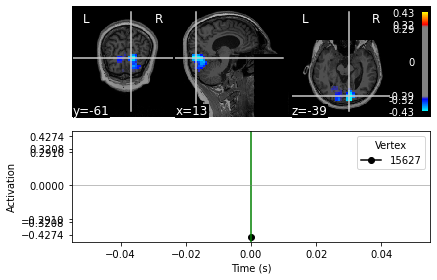

In [12]:
src = fwd['src']
%matplotlib inline
stc_arel.plot(src=src, subject=subject, subjects_dir=mri_dir, 
             mode='stat_map');

The above plot show the relative depression in the alpha following the onset of moving gratings. The blue island reflects the occipital depression in alpha power.

To browse the slice use the following command and the mouse to navigate:

In [13]:
#%matplotlib qt
#stc_arel.plot(src=src, subject=subject, subjects_dir=mri_dir, 
#             mode='stat_map');

C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Showing: t = 0.000 s, (48.1, -32.0, -59.2) mm, [25, 11, 9] vox, 11080 vertex


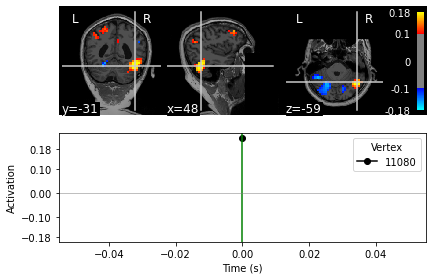

In [14]:
stc_aRvsL.plot(src=src, subject=subject, subjects_dir=mri_dir, 
              mode='stat_map', clim=dict(kind='value', pos_lims=[0.1,0.1,0.18]));

The sources in the posterior areas reflect the modulation of the alpha band activity when the partipant in attention to the right versus left moving gratings. The right orange island reflects the well-known ipsi-lateral reflective increase in alpha band power (the left island the contra-lateral alpha decrease).  

# Source modeling of modulations of gamma band activty

We will next localize the sources associated with the modulation in the 60 - 90 Hz gamma band. For this, we will apply the multitaper approach to ensure suffient spectral smoothing.

As a first step, calculate the CSD for the pre- and post-interval as well as all conditions. The bandwidth here is 2ΔF = 8 Hz and the time window ΔT = 0.475 s. This results in 3 tapers (as N <  2ΔF ΔT). 

In [15]:
csd_gleft_base =  csd_multitaper(epochs['left'],  fmin=60, fmax=90, tmin=-0.6,   tmax=-0.125, bandwidth = 8, adaptive=True, low_bias = True, verbose = True, n_jobs=4)
csd_gleft_act =   csd_multitaper(epochs['left'],  fmin=60, fmax=90, tmin= 0.125, tmax= 0.6,   bandwidth = 8, adaptive=True, low_bias = True, verbose = True, n_jobs=4)
csd_gright_base = csd_multitaper(epochs['right'], fmin=60, fmax=90, tmin=-0.6,   tmax=-0.125, bandwidth = 8, adaptive=True, low_bias = True, verbose = True, n_jobs=4)
csd_gright_act =  csd_multitaper(epochs['right'], fmin=60, fmax=90, tmin= 0.125, tmax= 0.6,   bandwidth = 8, adaptive=True, low_bias = True, verbose = True, n_jobs=4)

    Using multitaper spectrum estimation with 3 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/33 [00:00<?,       ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Para

[done]


[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.8s finished


    Using multitaper spectrum estimation with 3 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/33 [00:00<?,       ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Para

[done]


[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.7s finished


    Using multitaper spectrum estimation with 3 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/32 [00:00<?,       ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Para

[done]


[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.7s finished


    Using multitaper spectrum estimation with 3 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/32 [00:00<?,       ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Para

[done]


[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.7s finished


In [16]:
csd_gcommon = csd_gleft_base
csd_gcommon._data = (csd_gleft_base._data + csd_gright_base._data + csd_gleft_act._data + csd_gright_act._data)/4


### Derive the spatial filters for the gamma band

The filters will be calculated on the basis of the common CSD. The rank estimate based on the covariance matrix will be used. The deduced rank is due to the SSS as well as the ICA. We also here chose a 5% regularization parameter.


In [17]:
filters = make_dics(epochs.info, fwd, csd_gcommon.mean() , noise_csd=csd_gcommon.mean(), reg=0.05, pick_ori='max-power',
                        reduce_rank=True, real_filter=False, rank=rank)

Identifying common channels ...
Dropped the following channels:
['STI014', 'SYS201', 'STI013', 'SYS101', 'STI016', 'IASX-', 'IASX+', 'MISC002', 'STI009', 'ECG003', 'IASY+', 'STI003', 'IAS_Z', 'IAS_X', 'EOG002', 'STI102', 'MISC003', 'IAS_DY', 'STI006', 'IASY-', 'STI015', 'STI001', 'STI004', 'STI002', 'STI010', 'STI007', 'IAS_DX', 'EOG001', 'IASZ+', 'STI008', 'STI005', 'IAS_Y', 'MISC001', 'IASZ-', 'STI101', 'STI012', 'STI011']
Identifying common channels ...
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
Whitening the forward solution.
Computing rank from covariance with rank={'meg': 69}
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing rank from covariance with rank={'meg': 69}
Computing rank from covariance with rank={'meg': 69}
Computing DICS spatial filters...
Computing beamformer filters

C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Filter computation complete


### Apply the filters and plot the gamma modulation

The filters are then applied

In [18]:
stc_gleft_base, freqs = apply_dics_csd(csd_gleft_base.mean(), filters)
stc_gleft_act, freqs  = apply_dics_csd(csd_gleft_act.mean(), filters)
stc_gright_base, freqs = apply_dics_csd(csd_gright_base.mean(), filters)
stc_gright_act, freqs  = apply_dics_csd(csd_gright_act.mean(), filters)

Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]
Computing DICS source power...
[done]


Now calculate the relative modulation in gamma power with respect to the baseline:

In [19]:
stc_grel = ((stc_gleft_act + stc_gright_act) - (stc_gleft_base + stc_gright_base)) / (stc_gleft_base + stc_gright_base)

and subsequently the hemisperic lateralization with respect to attention:

In [20]:
stc_gRvsL = (stc_gright_act - stc_gleft_act) / (stc_gright_act + stc_gleft_act)

and plot the relative modulation. Note the increase in gamma power in visual cortex

C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Showing: t = 0.000 s, (-6.9, -57.0, -69.2) mm, [14, 6, 7] vox, 8528 vertex
Using control points [0.07128783 0.07805242 0.10257155]


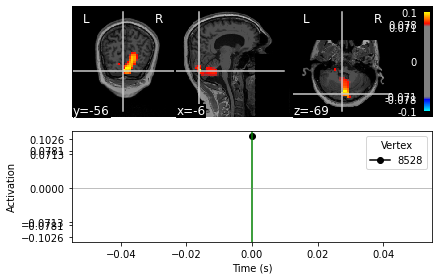

In [22]:
src = fwd['src']
stc_grel.plot(src=src, subject=subject, subjects_dir=mri_dir, mode='stat_map');

The increase of the gamma activity is correclty localized in early visual cortex along the calcarine sulcus.  

To illustrate the modulation in gamma band activity with attention write: 

C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Showing: t = 0.000 s, (53.1, -27.0, -69.2) mm, [26, 12, 7] vox, 8738 vertex


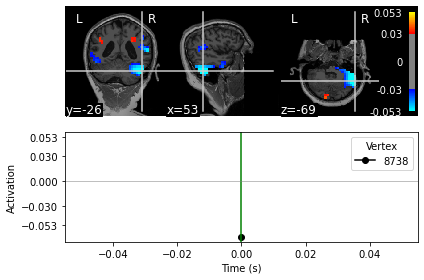

In [25]:
stc_gRvsL.plot(src=src, subject=subject, subjects_dir=mri_dir, 
              mode='stat_map', clim=dict(kind='value', pos_lims=[0.03,0.03,0.053]));
#stc_gRvsL.plot(src=src, subject=subject, subjects_dir=mri_dir, 
#              mode='stat_map');

The above plots should be interpreted with caution. The right hemisphere decrease is expected, but it is not complemented by an increase in the left hemisphetre. This result is most likely explained by the SNR being too low. 

## Preregistration and publications


Example for text to be used for publications and preregistration:

"The Dynamics Imaging of Coherent Sources (DICSs) approach (Gross et al., 2001) was applied to localize the modulations of oscillatory brain activity. To localize the modulation in the alpha band, the cross-spectral density (CSD) was calculated for the 8 to 12 Hz band using a multi-taper approach applying 2 Hz spectral smoothing. The CSD matrix was then calculated for the 300 - 800 ms stimulus interval in which the gratings were shown as well as the -800 - -300 ms pre-stimulus interval (using one DPSS taper). 
The combined CSD was used with the forward model to create a common spatial filter using a regularization corresponding to loading the diagonal of the covariance matrix with 5% of the sensor power. For each source, the orientation was optimized to maximize the power of the output. The spatial filter was then applied to the CSDs to calculate the relative change in alpha power. As similar approach was used for the gamma band now considering the 60 - 90 Hz band and 8 Hz spectral smoothing (resulting in 3 DPSS tapers). The pre-stimulus time-interval was -0.6 to -0.125 s and the post-stimulus interval was 0.125 to 0.6 s. "

## References

Gross J, Kujala J, Hamalainen M, Timmermann L, Schnitzler A, Salmelin R. (2001) Dynamic imaging of coherent sources: Studying neural interactions in the human brain. Proc Natl Acad Sci U S A. 98(2):694-9.